### Import packages

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7494395324801911102
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2262054473187841788
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12431794333484904351
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11982716928
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 5860953385435722748
physical_device_desc: "device: 0, name: TITAN Xp, pci bus id: 0000:84:00.0, compute capability: 6.1"
]


In [3]:
import time
import numpy as np
import glob
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [5]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
tf.config.gpu.set_per_process_memory_growth(True)

In [6]:
from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

In [7]:
tf.print()

In [8]:
from avgn.utils.paths import DATA_DIR, ensure_dir

In [9]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
                tf.keras.layers.Conv2D(
                    filters=16, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Conv2D(
                    filters=128, kernel_size=3, strides=(2, 2), activation="relu"
                ),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=8 * 8 * 128, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(8, 8, 128)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=16,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                tf.keras.layers.Conv2DTranspose(
                    filters=16,
                    kernel_size=3,
                    strides=(2, 2),
                    padding="SAME",
                    activation="relu",
                ),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1, 1), padding="SAME"
                ),
            ]
        )

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

In [10]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

In [11]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        #print(predictions)
        plt.imshow(predictions[i, :, :, 0], origin="lower")
        plt.axis("off")

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.show()

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
epochs = 100
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)
model = CVAE(latent_dim)

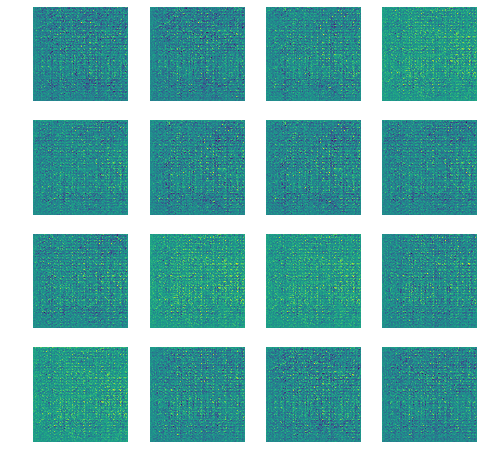

In [14]:
generate_and_save_images(model, 0, random_vector_for_generation)

### load data

In [15]:
if int(tf.__version__[0]) < 2:
    from tensorflow import FixedLenFeature, parse_single_example
else:
    from tensorflow.io import FixedLenFeature, parse_single_example


def _dtype_to_tf_feattype(dtype):
    """ reads from tfrecord in the three supported feature formats
    """
    if dtype is tf.float32:
        return tf.float32
    elif dtype is tf.string:
        return tf.string
    elif dtype is tf.int64:
        return tf.int64
    else:
        return tf.string


def _parse_function(example_proto, labels):
    """ parse dataset from tfrecord, and convert to correct format
    """
    # list features
    features = {
        lab: FixedLenFeature([], _dtype_to_tf_feattype(dtype))
        for lab, dtype, _ in labels
    }
    # parse features
    parsed_features = parse_single_example(example_proto, features)

    parse_list = []
    for lab, dtype, _return_val in labels:
        if _return_val:
            if dtype not in [tf.float32, tf.string, tf.int64]:
                parse_list.append(tf.io.decode_raw(parsed_features[lab], dtype))
            else:
                parse_list.append(parsed_features[lab])
    return parse_list

In [16]:
def recast_sylls(sylls):
    """ syllables are stored as uint8 matrices. This function
    recasts those syllables as float32, scales them, and resizes them
    """
    sylls = tf.dtypes.cast(sylls, tf.float32)
    sylls = sylls/255
    sylls = tf.reshape(sylls, (BATCH_SIZE, 128, 128,1))
    return sylls

In [17]:
def get_numex(raw_dataset):
    """ gets the number of examples in a raw dataset
    """
    num_ex = raw_dataset.map(lambda x: True)
    nex = np.sum([i.numpy() for i in iter(num_ex)])
    return nex

In [18]:
species = 'BF'
dataset = 'Koumura_Okanoya'

In [19]:
### a list of data information from the tfrecord file for parsing the dataset
# (name_of_dset, dtype_of_dset, return_value)
ds_labs = [
    ("syllable", tf.uint8, True),
    ("indv", tf.string, False),
    ("label", tf.string, False),
    ("length_s", tf.float32, False),
    ("orig_wav", tf.string, False),
    ("syll_start_rel_wav", tf.float32, False),
    ("wav_datetime", tf.string, False),
]

In [20]:
# tfrecord containing folder
tf_record_loc = DATA_DIR / species / dataset / 'syllable_tfrecord'
# get tfrecord files
filenames = [str(i) for i in tf_record_loc.glob('*.tfrecord')]
# create dataset from .tfrecord files
raw_dataset = tf.data.TFRecordDataset(filenames)
# parse the dataset
dset = raw_dataset.map(lambda x: _parse_function(x, labels=ds_labs))

In [21]:
# the number of examples in the dataset
nex = get_numex(raw_dataset)
nex

13896

In [22]:
BUFFER_SIZE = nex # the dataset size to grab
BATCH_SIZE = 64 # the size of each batch passed through
TAKE_SIZE = 1000 # the size of the testing dataset

In [23]:
# fill a buffer with buffer_size elements, then randomly shuffle from that buffer
dset = dset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)

In [24]:
# split the dataset into training and testing
train_data = dset.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = dset.take(TAKE_SIZE)
test_data = test_data.batch(BATCH_SIZE)

In [25]:
train_data, test_data, dataset

(<BatchDataset shapes: ((None, None),), types: (tf.uint8,)>,
 <BatchDataset shapes: ((None, None),), types: (tf.uint8,)>,
 'Koumura_Okanoya')

In [26]:
n_batches = int((BUFFER_SIZE-TAKE_SIZE)/BATCH_SIZE)
n_test_batches = int(TAKE_SIZE/BATCH_SIZE)
n_test_batches, n_batches

(15, 201)

In [27]:
next(iter(train_data))

(<tf.Tensor: id=28560, shape=(64, 16384), dtype=uint8, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>,)

In [30]:
@tf.function
def train(model, optimizer):
    # tfrecord containing folder
    tf_record_loc = DATA_DIR / species / dataset / 'syllable_tfrecord'
    # get tfrecord files
    filenames = [str(i) for i in tf_record_loc.glob('*.tfrecord')]
    # create dataset from .tfrecord files
    raw_dataset = tf.data.TFRecordDataset(filenames)
    # parse the dataset
    dset = raw_dataset.map(lambda x: _parse_function(x, labels=ds_labs))

    BUFFER_SIZE = nex # the dataset size to grab
    BATCH_SIZE = 64 # the size of each batch passed through
    TAKE_SIZE = 1000 # the size of the testing dataset

    # fill a buffer with buffer_size elements, then randomly shuffle from that buffer
    dset = dset.shuffle(buffer_size=BUFFER_SIZE, reshuffle_each_iteration=False)

    # split the dataset into training and testing
    train_data = dset.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
    train_data = train_data.batch(BATCH_SIZE)

    test_data = dset.take(TAKE_SIZE)
    test_data = test_data.batch(BATCH_SIZE)
    # training
    start_time = time.time()
    for batch in tqdm(range(n_batches)):
        train_x = recast_sylls(next(iter(train_data)))
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

In [31]:
for epoch in range(1, epochs + 1):
    train(model, optimizer)

W0429 22:45:51.086754 139874574415616 tf_logging.py:161] Entity <bound method Path.glob of PosixPath('/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/BF/Koumura_Okanoya/syllable_tfrecord')> could not be transformed and will be staged without change. Error details can be found in the logs when running with the env variable AUTOGRAPH_VERBOSITY >= 1. Please report this to the AutoGraph team. Cause: Generators are not supported by AutoGraph


RuntimeError: dataset.__iter__() is only supported when eager execution is enabled.

In [ ]:
for epoch in range(1, epochs + 1):
    # training
    start_time = time.time()
    for batch in tqdm(range(n_batches)):
        train_x = recast_sylls(next(iter(train_data)))
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    # test/plotting
    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for batch_test in range(n_test_batches):
            test_x = recast_sylls(next(iter(test_data)))
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print(
            "Epoch: {}, Test set ELBO: {}, "
            "time elapse for current epoch {}".format(
                epoch, elbo, end_time - start_time
            )
        )
        generate_and_save_images(model, epoch, random_vector_for_generation)

In [ ]:
generate_and_save_images(
        model, epoch, random_vector_for_generation)